In [1]:
from our_utils import *
from noisy_causal_discovery import *

from cdt.metrics import SHD_CPDAG
import ges
import matplotlib.pyplot as plt
import numpy as np
import sempler
from sempler.generators import dag_avg_deg
from scores import HuberScore
from tqdm import tqdm 
import numpy as np

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [2]:
''' Choose general experiment parameters. '''

trials = 100         # no. of trials to average over
err_lvl = 0.05       # signficance level
delta = 0.5          # delta Huber parameter
no_graphs = 10       # number of graph variations
n, d = 100, 15       # sample size, graph dimension
avg_deg = 1          # average degree

split_choices = [0.05, 0.5, 0.95] # splitting baselines

eps_choices = [0.01, 0.04, 0.08, 0.16, 0.24] # privacy parameters
max_iter = 5 # noisy-ges parameter setting

split_shd, noisy_shd = {}, {}        # initialize the SHD results dictionaries
split_widths, noisy_widths = {}, {}  # initialize the CI widths results dictionaries

In [3]:
''' Compute the splitting baselines SHD to graph selected by the full data
    and the estimated mean interval width. '''

for split in split_choices:

    split_shd[(split, delta)] = []
    split_widths[(split, delta)] = []

    for trial in tqdm(range(trials)):
        np.random.seed(trial)

        G = dag_avg_deg(d, avg_deg, w_min=2, w_max=4)
        data = sempler.LGANM(G, (0,0), (1,1)).sample(n=n)

        full_cpdag_estimate, _ = noisy_fit(HuberScore(data, delta=delta))

        select_data, infer_data = subsample(data, split)
        split_cpdag_estimate, _ = noisy_fit(HuberScore(select_data, delta=delta))

        split_shd[(split, delta)].append(np.sum(np.abs(split_cpdag_estimate - full_cpdag_estimate)))

        if np.any(split_cpdag_estimate) > 0:
            split_widths[(split, delta)].append(get_CI_width(infer_data, split_cpdag_estimate, err_lvl))
        else:
            split_widths[(split, delta)].append(0)

    print("For split =", split,"data-splitting attains avg. SHD:", \
          np.round(np.mean(split_shd[(split, delta)]), 2))

    print("For split =", split,"data-splitting attains avg. CI widths:", \
          np.round(np.mean(split_widths[(split, delta)]), 2))

100%|██████████| 100/100 [22:58<00:00, 13.79s/it]


For split = 0.05 data-splitting attains avg. SHD: 33.98
For split = 0.05 data-splitting attains avg. CI widths: 0.56


100%|██████████| 100/100 [21:41<00:00, 13.02s/it]


For split = 0.5 data-splitting attains avg. SHD: 23.62
For split = 0.5 data-splitting attains avg. CI widths: 0.79


100%|██████████| 100/100 [21:11<00:00, 12.71s/it]

For split = 0.95 data-splitting attains avg. SHD: 10.56
For split = 0.95 data-splitting attains avg. CI widths: 2.54


In [4]:
''' Compute the noisy-select SHD to graph selected by the full data
    and the estimated mean interval width for varying settings of epsilon. '''

for eps in eps_choices:

    eps_max = eps / (4 * max_iter)
    eps_thrsh = eps / 4

    cum_eps = 2*(max_iter*eps_max + eps_thrsh)

    err_lvl_adj = alpha_tilde(err_lvl, eps, n)

    noisy_shd[(eps, delta)] = []
    noisy_widths[(eps, delta)] = []

    for trial in tqdm(range(trials)):
        np.random.seed(trial)

        G = dag_avg_deg(d, avg_deg, w_min=2, w_max=4)
        data = sempler.LGANM(G, (0,0), (1,1)).sample(n=n)

        full_cpdag_estimate, _ = noisy_fit(HuberScore(data, delta=delta))

        noisy_cpdag_estimate, _ = noisy_fit(HuberScore(data, delta=delta), \
                                           eps_max=eps_max, eps_thrsh=eps_thrsh, max_iter=max_iter)

        noisy_shd[(eps, delta)].append(np.sum(np.abs(noisy_cpdag_estimate - full_cpdag_estimate)))

        if np.any(noisy_cpdag_estimate):
            noisy_widths[(eps, delta)].append(get_CI_width(data, noisy_cpdag_estimate, err_lvl_adj))
        else:
            noisy_widths[(eps, delta)].append(0)

    print("For eps =", eps, "noisy-ges attains avg. SHD:", \
          np.round(np.mean(noisy_shd[(eps, delta)]), 2))

    print("For eps =", eps,"noisy-ges attains avg. CI widths:", \
          np.round(np.mean(noisy_widths[(eps, delta)]), 2))

100%|██████████| 100/100 [11:25<00:00,  6.85s/it]


For eps = 0.01 noisy-ges attains avg. SHD: 28.0
For eps = 0.01 noisy-ges attains avg. CI widths: 0.25


100%|██████████| 100/100 [11:28<00:00,  6.88s/it]


For eps = 0.04 noisy-ges attains avg. SHD: 28.22
For eps = 0.04 noisy-ges attains avg. CI widths: 0.18


100%|██████████| 100/100 [11:34<00:00,  6.95s/it]


For eps = 0.08 noisy-ges attains avg. SHD: 28.18
For eps = 0.08 noisy-ges attains avg. CI widths: 0.21


100%|██████████| 100/100 [11:47<00:00,  7.07s/it]


For eps = 0.16 noisy-ges attains avg. SHD: 28.19
For eps = 0.16 noisy-ges attains avg. CI widths: 0.54


100%|██████████| 100/100 [12:11<00:00,  7.32s/it]

For eps = 0.24 noisy-ges attains avg. SHD: 27.96
For eps = 0.24 noisy-ges attains avg. CI widths: 0.79


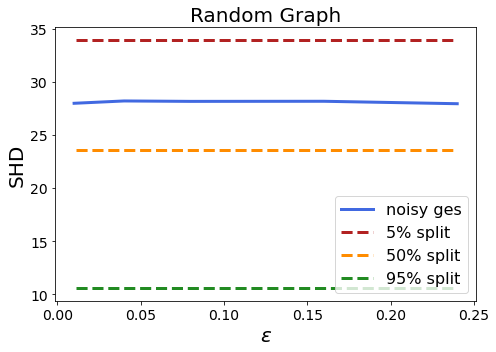

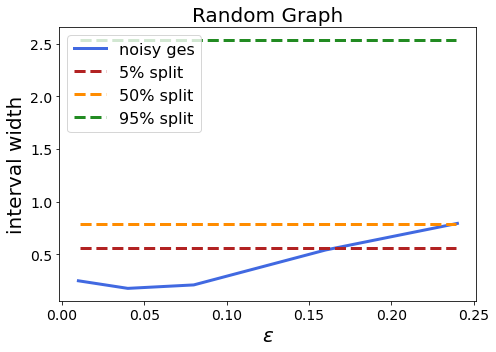

In [5]:
''' Plot the corresponding results. '''

colors=['firebrick', 'darkorange', 'forestgreen']

plt.figure(figsize=(7, 5))
plt.plot(eps_choices, [np.mean(noisy_shd[(eps, delta)]) for eps in eps_choices], \
         color='royalblue', linewidth=3, label="noisy ges")
for i, split in enumerate(split_choices):
    plt.axhline(y=np.mean(split_shd[(split, delta)]), linestyle='--', xmin=0.05, xmax=0.95, \
                color=colors[i], linewidth=3, label=str(int(split*100))+'% split')
plt.xlabel("$\epsilon$", fontsize=20)
plt.ylabel("SHD", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, loc=4)
plt.title("Random Graph", fontsize=20)
plt.tight_layout()
plt.savefig('noisy_ges_plot_shd.pdf')
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(eps_choices, [np.mean(noisy_widths[(eps, delta)]) for eps in eps_choices], \
         color='royalblue', linewidth=3, label="noisy ges")
for i, split in enumerate(split_choices):
    plt.axhline(y=np.mean(split_widths[(split, delta)]), linestyle='--', xmin=0.05, xmax=0.95, \
                color=colors[i], linewidth=3, label=str(int(split*100))+'% split')
plt.xlabel("$\epsilon$", fontsize=20)
plt.ylabel("interval width", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, loc=2)
plt.title("Random Graph", fontsize=20)
plt.tight_layout()
plt.savefig('noisy_ges_plot_width.pdf')
plt.show()

In [6]:
''' [EXTRA] See SHD to *true* graph for full data. '''

full_shd = []
for trial in tqdm(range(trials)):
    np.random.seed(trial)

    G = dag_avg_deg(d, avg_deg, w_min=2, w_max=4) # strengths between 2 and 4
    data = sempler.LGANM(G, (0,0), (1,1)).sample(n=n)     # normalized data

    cpdag_estimate, _ = noisy_fit(HuberScore(data, delta=delta))

    full_shd.append(SHD_CPDAG(G, cpdag_estimate))
    
print(f"The shd to the *true* graph using the full data for selection is: {np.round(np.mean(full_shd), 2)}")

100%|██████████| 100/100 [12:57<00:00,  7.77s/it]

The shd to the *true* graph using the full data for selection is: 14.69
